# Self-supervised learning in 3D images

Use the Doersch-style method as described in [1]

    [1] M. Blendowski et al. "How to Learn from Unlabeled Volume Data:
        Self-supervised 3D Context Feature Learning." MICCAI. 2019.

## Setup notebook

In [1]:
from typing import Callable, List, Optional, Tuple, Union

from glob import glob
import math
import os
import random
import sys

gpu_id = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f'{gpu_id}'

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

from selfsupervised3d import *

 Support in-notebook plotting

In [2]:
%matplotlib inline

Report versions

In [3]:
print('numpy version: {}'.format(np.__version__))
from matplotlib import __version__ as mplver
print('matplotlib version: {}'.format(mplver))
print(f'pytorch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

numpy version: 1.17.2
matplotlib version: 3.1.1
pytorch version: 1.5.0
torchvision version: 0.6.0a0+82fd1c8


In [4]:
pv = sys.version_info
print('python version: {}.{}.{}'.format(pv.major, pv.minor, pv.micro))

python version: 3.7.7


Reload packages where content for package development

In [5]:
%load_ext autoreload
%autoreload 2

Check GPU(s)

In [6]:
!nvidia-smi

Fri May  1 10:10:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M40 24GB      Off  | 00000000:02:00.0 Off |                    0 |
| N/A   28C    P8    16W / 250W |      0MiB / 22945MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40 24GB      Off  | 00000000:03:00.0 Off |                    0 |
| N/A   40C    P0    58W / 250W |    556MiB / 22945MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [7]:
assert torch.cuda.is_available()
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

Set seeds for better reproducibility. See [this note](https://pytorch.org/docs/stable/notes/faq.html#my-data-loader-workers-return-identical-random-numbers) before using multiprocessing.

In [8]:
seed = 1336
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Setup training and validation data

Get the location of the training (and validation) data

In [9]:
train_dir = '/iacl/pg20/jacobr/ixi/subsets/hh/'
t1_dir = os.path.join(train_dir, 't1')
t2_dir = os.path.join(train_dir, 't2')

In [10]:
t1_fns = glob(os.path.join(t1_dir, '*.nii*'))
t2_fns = glob(os.path.join(t2_dir, '*.nii*'))
assert len(t1_fns) == len(t2_fns) and len(t1_fns) != 0

## Look at example training dataset

Look at an axial view of the source T1-weighted (T1-w) and target T2-weighted (T2-w) images.

In [11]:
def imshow(x, ax, title, n_rot=3):
    ax.imshow(np.rot90(x,n_rot), aspect='equal', cmap='gray')
    ax.set_title(title,fontsize=22)
    ax.axis('off')

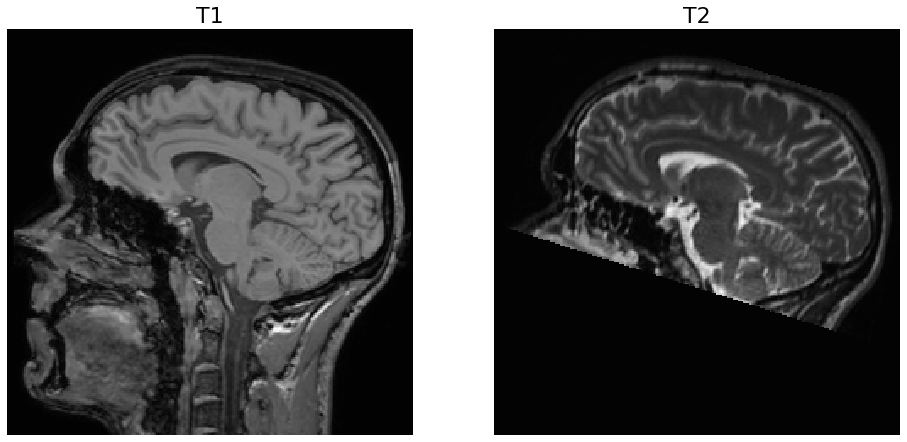

In [12]:
j = 100
t1_ex, t2_ex = nib.load(t1_fns[0]).get_data(), nib.load(t2_fns[0]).get_data()
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
imshow(t1_ex[...,j], ax1, 'T1', 1)
imshow(t2_ex[...,j], ax2, 'T2', 1)

In [13]:
x = torch.from_numpy(t1_ex).unsqueeze(0)

In [14]:
(ctr, qry), goal = doersch_patches(x, patch_size=0.5, patch_dim=96)

In [15]:
print(goal.item())

5


In [16]:
ctr = ctr.squeeze().cpu().detach().numpy()
qry = qry.squeeze().cpu().detach().numpy()

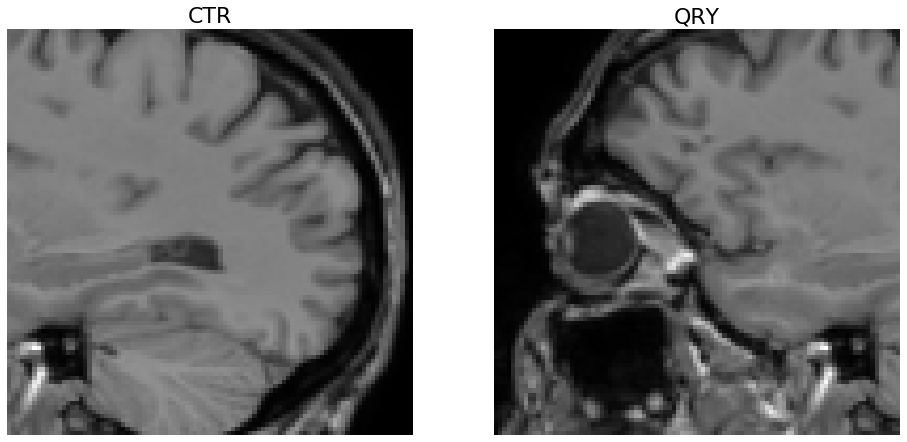

In [17]:
j = 12
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
imshow(ctr[...,j], ax1, 'CTR', 1)
imshow(qry[...,j], ax2, 'QRY', 1)

## Setup training

Hyperparameters, optimizers, logging, etc.

In [18]:
data_dirs = [t1_dir]

In [19]:
# system setup
load_model = False

# logging setup
log_rate = 10  # print losses every log_rate epochs
version = 'doersch_v1'  # naming scheme of model to load
save_rate = 100   # save models every save_rate epochs

# model, optimizer, loss, and training parameters
valid_split = 0.1
batch_size = 8
n_jobs = 8
n_epochs = 500
input_channels = len(data_dirs)
descriptor_size = 192
use_adam = True
opt_kwargs = dict(lr=1e-3, betas=(0.9,0.99), weight_decay=1e-6) if use_adam else \
             dict(lr=5e-3, momentum=0.9)
use_scheduler = True
scheduler_kwargs = dict(step_size=100, gamma=0.5)

In [20]:
def init_fn(worker_id):
    random.seed((torch.initial_seed() + worker_id) % (2**32))
    np.random.seed((torch.initial_seed() + worker_id) % (2**32))

In [21]:
# setup training and validation dataloaders
dataset = DoerschDataset(data_dirs)
num_train = len(dataset)
indices = list(range(num_train))
split = int(valid_split * num_train)
valid_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(valid_idx))
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, 
                          worker_init_fn=init_fn, num_workers=n_jobs,
                          pin_memory=True, collate_fn=doersch_collate)
valid_loader = DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size, 
                          worker_init_fn=init_fn, num_workers=n_jobs,
                          pin_memory=True, collate_fn=doersch_collate)

In [22]:
print(f'Number of training images: {num_train-split}')
print(f'Number of validation images: {split}')

Number of training images: 121
Number of validation images: 13


In [23]:
embedding_model = DoerschNet(input_channels=input_channels, descriptor_size=descriptor_size)
decoder_model = DoerschDecodeNet(descriptor_size=descriptor_size)

In [24]:
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [25]:
print(f'Number of trainable parameters in embedding model: {num_params(embedding_model)}')
print(f'Number of trainable parameters in decoder model: {num_params(decoder_model)}')

Number of trainable parameters in embedding model: 393392
Number of trainable parameters in decoder model: 31238


In [26]:
if load_model: 
    embedding_model.load_state_dict(torch.load(f'embedding_model_{version}.pth'))
    decoder_model.load_state_dict(torch.load(f'decoder_model_{version}.pth'))

In [27]:
embedding_model.to(device)
decoder_model.to(device)
optim_cls = torch.optim.AdamW if use_adam else torch.optim.SGD
embedding_opt = optim_cls(embedding_model.parameters(), **opt_kwargs)
decoder_opt = optim_cls(decoder_model.parameters(), **opt_kwargs)
criterion = nn.CrossEntropyLoss()
if use_scheduler: 
    embedding_scheduler = torch.optim.lr_scheduler.StepLR(embedding_opt, **scheduler_kwargs)
    decoder_scheduler = torch.optim.lr_scheduler.StepLR(decoder_opt, **scheduler_kwargs)

## Train model

In [28]:
train_losses, valid_losses = [], []
n_batches = len(train_loader)

In [29]:
for t in range(1, n_epochs + 1):
    # training
    t_losses = []
    embedding_model.train()
    decoder_model.train()
    for i, ((ctr, qry), goal) in enumerate(train_loader):
        ctr, qry, goal = ctr.to(device), qry.to(device), goal.to(device)
        embedding_opt.zero_grad()
        decoder_opt.zero_grad()
        ctr_f = embedding_model(ctr)
        qry_f = embedding_model(qry)
        out = decoder_model(ctr_f, qry_f)
        loss = criterion(out, goal)
        t_losses.append(loss.item())
        loss.backward()
        embedding_opt.step()
        decoder_opt.step()
    train_losses.append(t_losses)

    # validation
    v_losses = []
    embedding_model.eval()
    decoder_model.eval()
    with torch.no_grad():
        for i, ((ctr, qry), goal) in enumerate(valid_loader):
            ctr, qry, goal = ctr.to(device), qry.to(device), goal.to(device)
            ctr_f = embedding_model(ctr)
            qry_f = embedding_model(qry)
            out = decoder_model(ctr_f, qry_f)
            loss = criterion(out, goal)
            v_losses.append(loss.item())
        valid_losses.append(v_losses)

    # log, step scheduler, and save results from epoch
    if not np.all(np.isfinite(t_losses)): 
        raise RuntimeError('NaN or Inf in training loss, cannot recover. Exiting.')
    if t % log_rate == 0:
        log = (f'Epoch: {t} - TL: {np.mean(t_losses):.2e}, VL: {np.mean(v_losses):.2e}')
        print(log)
    if use_scheduler:
        embedding_scheduler.step()
        decoder_scheduler.step()
    if t % save_rate == 0:
        torch.save(embedding_model.state_dict(), f'embedding_model_{version}_{t}.pth')
        torch.save(decoder_model.state_dict(), f'decoder_model_{version}_{t}.pth')

Epoch: 10 - TL: 1.49e+00, VL: 1.42e+00
Epoch: 20 - TL: 1.01e+00, VL: 9.75e-01
Epoch: 30 - TL: 5.06e-01, VL: 6.65e-01
Epoch: 40 - TL: 2.19e-01, VL: 3.00e-01
Epoch: 50 - TL: 5.27e-01, VL: 3.23e-01
Epoch: 60 - TL: 2.49e-01, VL: 4.91e-02
Epoch: 70 - TL: 1.80e-01, VL: 1.63e-02
Epoch: 80 - TL: 1.81e-01, VL: 4.25e-02
Epoch: 90 - TL: 1.03e-01, VL: 1.98e-02
Epoch: 100 - TL: 9.27e-02, VL: 1.42e-02
Epoch: 110 - TL: 5.76e-02, VL: 2.66e-02
Epoch: 120 - TL: 1.43e-02, VL: 2.15e-01
Epoch: 130 - TL: 6.47e-02, VL: 3.49e-03
Epoch: 140 - TL: 1.62e-02, VL: 2.23e-02
Epoch: 150 - TL: 1.91e-02, VL: 2.15e-02
Epoch: 160 - TL: 1.17e-02, VL: 4.23e-03
Epoch: 170 - TL: 4.91e-03, VL: 1.75e-01
Epoch: 180 - TL: 5.40e-02, VL: 1.68e-03
Epoch: 190 - TL: 1.23e-02, VL: 6.21e-03
Epoch: 200 - TL: 4.46e-02, VL: 2.27e-03
Epoch: 210 - TL: 6.98e-03, VL: 2.30e-03
Epoch: 220 - TL: 3.03e-02, VL: 1.67e-03
Epoch: 230 - TL: 3.76e-02, VL: 5.54e-03
Epoch: 240 - TL: 2.38e-02, VL: 1.67e-03
Epoch: 250 - TL: 5.72e-02, VL: 1.31e-03
Epoch: 26

In [30]:
save_model = True
if save_model:
    torch.save(embedding_model.state_dict(), f'embedding_model_{version}.pth')
    torch.save(decoder_model.state_dict(), f'decoder_model_{version}.pth')

## Analyze training

In [31]:
def tidy_losses(train, valid):
    out = {'epoch': [], 'type': [], 'value': [], 'phase': []}
    for i, (tl,vl) in enumerate(zip(train,valid),1):
        for tli in tl:
            out['epoch'].append(i)
            out['type'].append('loss')
            out['value'].append(tli)
            out['phase'].append('train')
        for vli in vl:
            out['epoch'].append(i)
            out['type'].append('loss')
            out['value'].append(vli)
            out['phase'].append('valid')
    return pd.DataFrame(out)

In [32]:
losses = tidy_losses(train_losses, valid_losses)

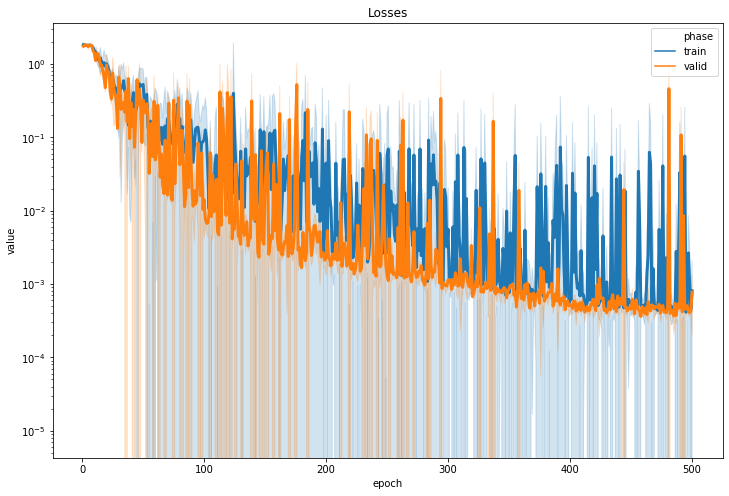

In [33]:
f, ax1 = plt.subplots(1,1,figsize=(12, 8),sharey=True)
sns.lineplot(x='epoch',y='value',hue='phase',data=losses,ci='sd',ax=ax1,lw=3);
ax1.set_yscale('log');
ax1.set_title('Losses');

In [34]:
save_losses = False
if save_losses:
    f.savefig(f'losses_{version}.pdf')
    losses.to_csv(f'losses_{version}.csv')